In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import ARCH, GARCH

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from mlforecast import MLForecast

warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

/Users/marcopeix/miniconda3/envs/bitbang-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['figure.figsize'] = (9,6)

In [3]:
url = "https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesForecastingInPython/refs/heads/master/data/AMZN.csv"
df = pd.read_csv(url, parse_dates=['Date'])
df.insert(0, 'unique_id', 1)

df = df[['unique_id', 'Date', 'Adj Close']]
df = df.rename(columns={'Adj Close': 'y', 'Date': 'ds'})

df.head()

,unique_id,ds,y
0,1,2021-10-05,161.050
1,1,2021-10-06,163.100
2,1,2021-10-07,165.122
3,1,2021-10-08,164.431
4,1,2021-10-11,162.315


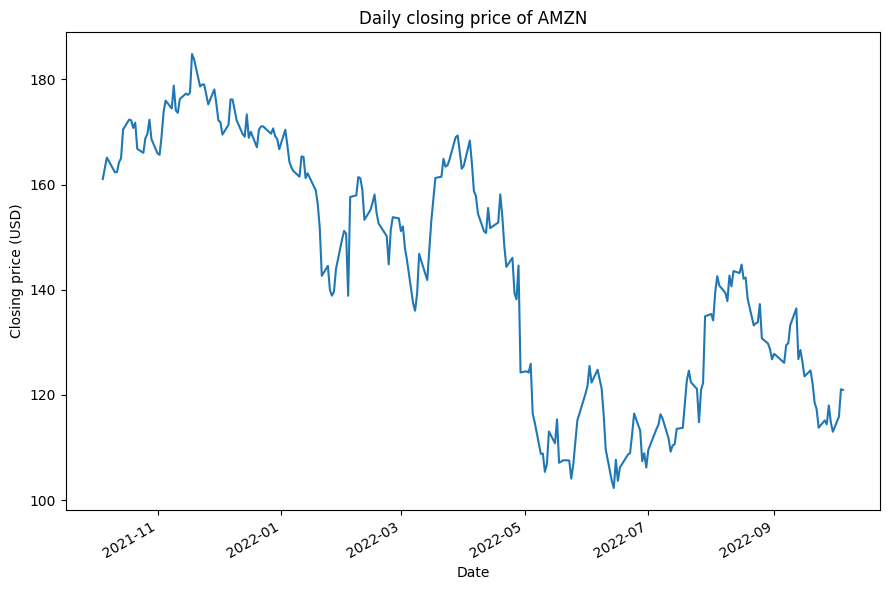

In [4]:
fig, ax = plt.subplots()

ax.plot(df['ds'], df['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
ax.set_title('Daily closing price of AMZN')

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
df['return'] = df['y'].pct_change()
df = df.dropna(how='any')
df.head()

,unique_id,ds,y,return
1,1,2021-10-06,163.100,1.273e-02
2,1,2021-10-07,165.122,1.239e-02
3,1,2021-10-08,164.431,-4.182e-03
4,1,2021-10-11,162.315,-1.287e-02
5,1,2021-10-12,162.367,3.173e-04


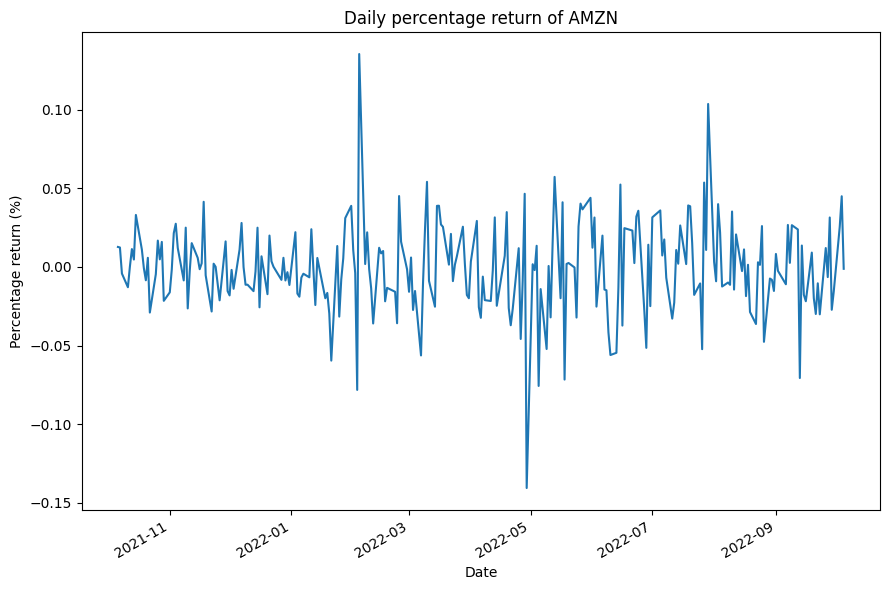

In [6]:
fig, ax = plt.subplots()

ax.plot(df['ds'], df['return'])
ax.set_xlabel('Date')
ax.set_ylabel('Percentage return (%)')
ax.set_title('Daily percentage return of AMZN')

fig.autofmt_xdate()
plt.tight_layout()

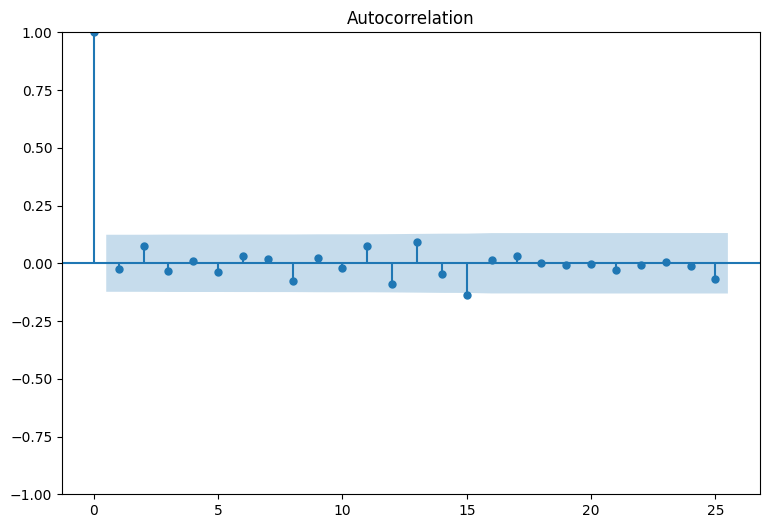

In [7]:
plot_acf(df['return']);

In [8]:
df['sq_return'] = df['return']**2
df.head()

,unique_id,ds,y,return,sq_return
1,1,2021-10-06,163.100,1.273e-02,1.621e-04
2,1,2021-10-07,165.122,1.239e-02,1.535e-04
3,1,2021-10-08,164.431,-4.182e-03,1.749e-05
4,1,2021-10-11,162.315,-1.287e-02,1.656e-04
5,1,2021-10-12,162.367,3.173e-04,1.007e-07


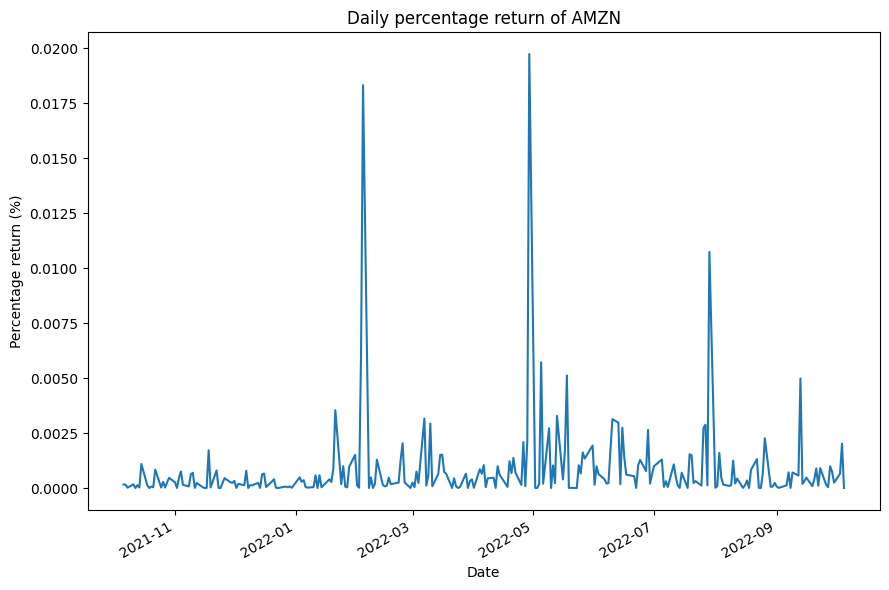

In [9]:
fig, ax = plt.subplots()

ax.plot(df['ds'], df['sq_return'])
ax.set_xlabel('Date')
ax.set_ylabel('Percentage return (%)')
ax.set_title('Daily percentage return of AMZN')

fig.autofmt_xdate()
plt.tight_layout()

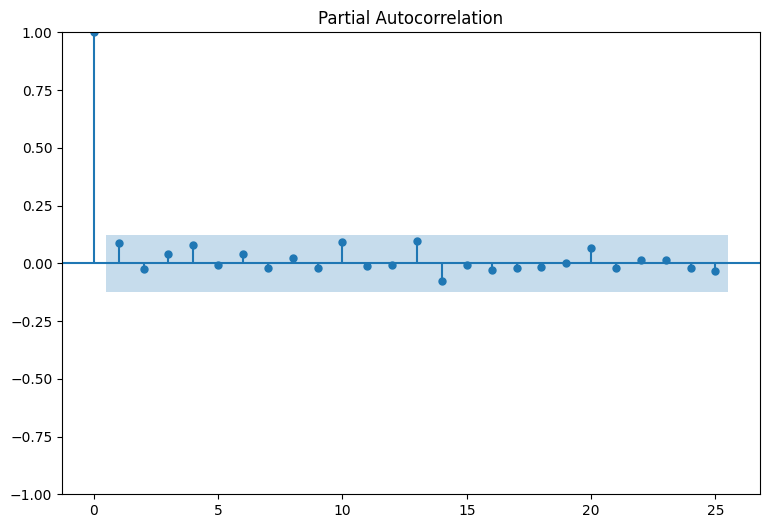

In [10]:
plot_pacf(df['sq_return']);

## ARCH

In [11]:
arch1 = ARCH(p=1)
arch2 = ARCH(p=2)
arch3 = ARCH(p=3)

In [12]:
df_fit = df[['unique_id', 'ds', 'return']]
df_fit.head()

,unique_id,ds,return
1,1,2021-10-06,1.273e-02
2,1,2021-10-07,1.239e-02
3,1,2021-10-08,-4.182e-03
4,1,2021-10-11,-1.287e-02
5,1,2021-10-12,3.173e-04


In [13]:
h = 5

sf = StatsForecast(models=[arch1, arch2, arch3], freq='B')

cv_df = sf.cross_validation(h=h, 
                            df=df_fit, 
                            n_windows=10, 
                            step_size=h,
                            target_col='return',
                            refit=True)

cv_df.head()

,unique_id,ds,cutoff,return,ARCH(1),ARCH(2),ARCH(3)
0,1,2022-07-27,2022-07-26,0.054,0.065,0.080,0.065
1,1,2022-07-28,2022-07-26,0.011,-0.029,-0.030,-0.029
2,1,2022-07-29,2022-07-26,0.104,-0.015,-0.026,-0.017
3,1,2022-08-01,2022-07-26,0.003,-0.027,-0.053,-0.028
4,1,2022-08-02,2022-07-26,-0.009,0.025,0.043,0.025


In [14]:
cv_df = cv_df.merge(df[['ds', 'y']], on='ds', how='left')
cv_df.head()

,unique_id,ds,cutoff,return,ARCH(1),ARCH(2),ARCH(3),y
0,1,2022-07-27,2022-07-26,0.054,0.065,0.080,0.065,120.97
1,1,2022-07-28,2022-07-26,0.011,-0.029,-0.030,-0.029,122.28
2,1,2022-07-29,2022-07-26,0.104,-0.015,-0.026,-0.017,134.95
3,1,2022-08-01,2022-07-26,0.003,-0.027,-0.053,-0.028,135.39
4,1,2022-08-02,2022-07-26,-0.009,0.025,0.043,0.025,134.16


In [15]:
initial_value = df.loc[df['ds'] == '2022-07-27', 'y'].values[0]
initial_value

np.float64(120.970001)

In [16]:
cv_df['ARCH(1)'] = initial_value * (1+cv_df['ARCH(1)']).cumprod()
cv_df['ARCH(2)'] = initial_value * (1+cv_df['ARCH(2)']).cumprod()
cv_df['ARCH(3)'] = initial_value * (1+cv_df['ARCH(3)']).cumprod()
cv_df.head()

,unique_id,ds,cutoff,return,ARCH(1),ARCH(2),ARCH(3),y
0,1,2022-07-27,2022-07-26,0.054,128.834,130.662,128.804,120.97
1,1,2022-07-28,2022-07-26,0.011,125.153,126.711,125.060,122.28
2,1,2022-07-29,2022-07-26,0.104,123.215,123.405,122.964,134.95
3,1,2022-08-01,2022-07-26,0.003,119.879,116.877,119.572,135.39
4,1,2022-08-02,2022-07-26,-0.009,122.864,121.867,122.549,134.16


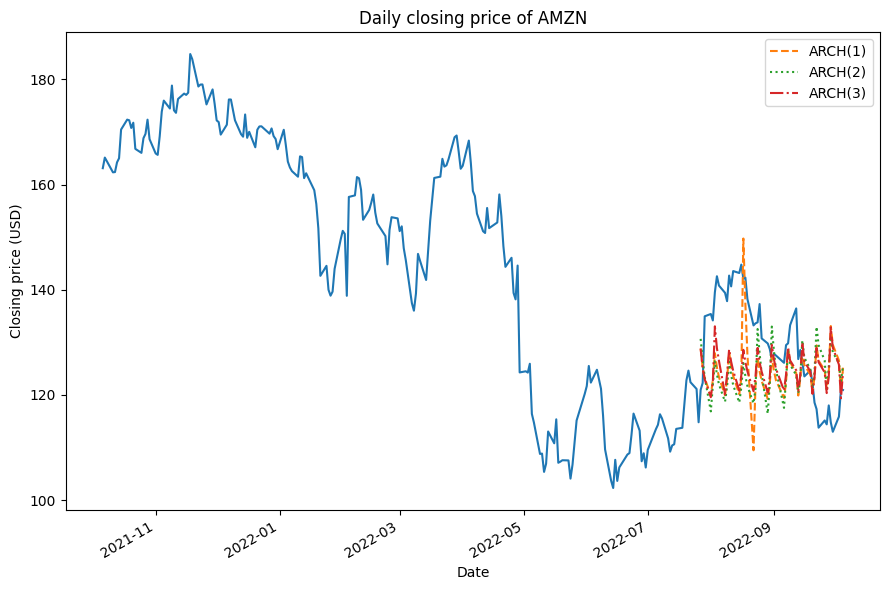

In [17]:
fig, ax = plt.subplots()

ax.plot(df['ds'], df['y'])
ax.plot(cv_df['ds'], cv_df['ARCH(1)'], label='ARCH(1)', ls='--')
ax.plot(cv_df['ds'], cv_df['ARCH(2)'], label='ARCH(2)', ls=':')
ax.plot(cv_df['ds'], cv_df['ARCH(3)'], label='ARCH(3)', ls='-.')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
ax.set_title('Daily closing price of AMZN')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
eval_df = cv_df.drop(['ds', 'cutoff', 'return'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae])
evaluation

,unique_id,metric,ARCH(1),ARCH(2),ARCH(3)
0,1,mae,9.825,10.768,9.302


## GARCH

In [19]:
garch1 = GARCH(p=1, q=1)
garch2 = GARCH(p=2, q=2)
garch3 = GARCH(p=3, q=3)

In [20]:
sf = StatsForecast(models=[garch1, garch2, garch3], freq='B')

cv_df = sf.cross_validation(h=h, 
                            df=df_fit, 
                            n_windows=10, 
                            step_size=h,
                            target_col='return',
                            refit=True)

cv_df.head()

,unique_id,ds,cutoff,return,"GARCH(1,1)","GARCH(2,2)","GARCH(3,3)"
0,1,2022-07-27,2022-07-26,0.054,0.056,0.057,0.077
1,1,2022-07-28,2022-07-26,0.011,-0.025,-0.024,-0.038
2,1,2022-07-29,2022-07-26,0.104,-0.020,-0.018,-0.021
3,1,2022-08-01,2022-07-26,0.003,-0.037,-0.035,-0.037
4,1,2022-08-02,2022-07-26,-0.009,0.030,0.030,0.035


In [21]:
cv_df = cv_df.merge(df[['ds', 'y']], on='ds', how='left')
cv_df['GARCH(1,1)'] = initial_value * (1+cv_df['GARCH(1,1)']).cumprod()
cv_df['GARCH(2,2)'] = initial_value * (1+cv_df['GARCH(2,2)']).cumprod()
cv_df['GARCH(3,3)'] = initial_value * (1+cv_df['GARCH(3,3)']).cumprod()

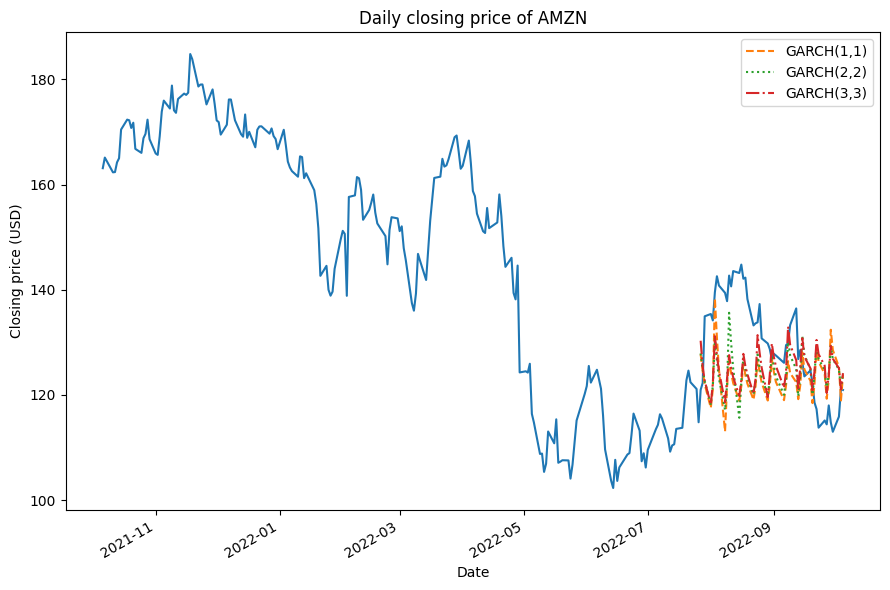

In [22]:
fig, ax = plt.subplots()

ax.plot(df['ds'], df['y'])
ax.plot(cv_df['ds'], cv_df['GARCH(1,1)'], label='GARCH(1,1)', ls='--')
ax.plot(cv_df['ds'], cv_df['GARCH(2,2)'], label='GARCH(2,2)', ls=':')
ax.plot(cv_df['ds'], cv_df['GARCH(3,3)'], label='GARCH(3,3)', ls='-.')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
ax.set_title('Daily closing price of AMZN')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

In [23]:
eval_df = cv_df.drop(['ds', 'cutoff', 'return'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae])
evaluation

,unique_id,metric,"GARCH(1,1)","GARCH(2,2)","GARCH(3,3)"
0,1,mae,10.313,9.713,9.478


## Forecasting with ML models and features

In [24]:
data_url = 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv'
df = pd.read_csv(data_url, parse_dates=['Datetime'])
df.columns = ['ds', 'y']
df.insert(0, 'unique_id', 'PJM')
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
df.head()

,unique_id,ds,y
0,PJM,1998-04-01 01:00:00,22259.0
1,PJM,1998-04-01 02:00:00,21244.0
2,PJM,1998-04-01 03:00:00,20651.0
3,PJM,1998-04-01 04:00:00,20421.0
4,PJM,1998-04-01 05:00:00,20713.0


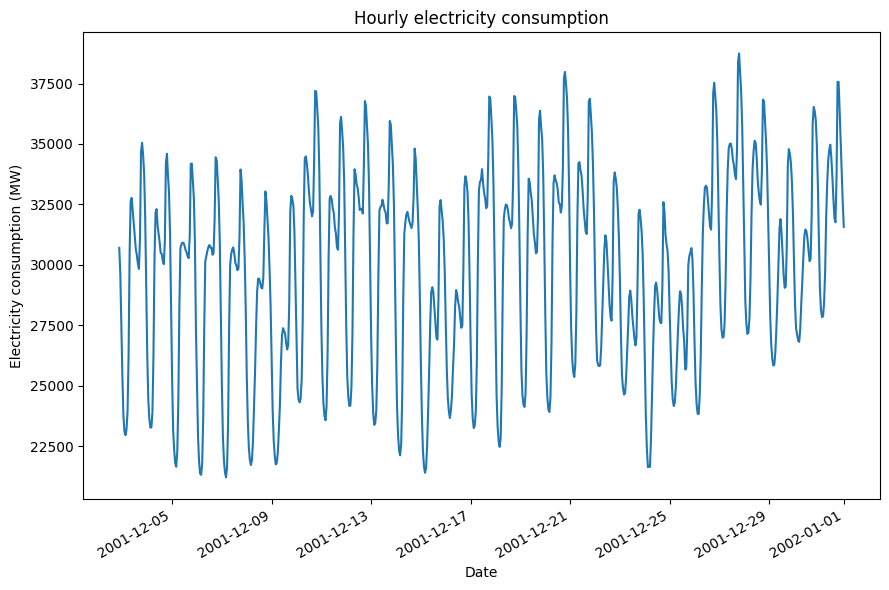

In [25]:
fig, ax = plt.subplots()

ax.plot(df['ds'][-700:], df['y'][-700:])
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
threshold_time = df['ds'].max() - pd.Timedelta(hours=24)

df_train = df[df['ds'] <= threshold_time]
df_test = df[df['ds'] > threshold_time]

print(len(df_train), len(df_test))

32872 24


## Analyzing seasonality and frequencies

In [27]:
from scipy.fftpack import fft, fftfreq

def analyze_frequencies(signal, sampling_rate):
    
    # Perform FFT
    signal = signal.values
    n = len(signal)
    fft_values = fft(signal)
    
    # Get frequencies corresponding to FFT values
    # For hourly data, this gives us frequencies in cycles per day
    freq = fftfreq(n, 1/sampling_rate)
    
    # Get positive frequencies only (up to Nyquist frequency)
    positive_freq_idx = np.arange(1, n//2)
    frequencies = freq[positive_freq_idx]
    amplitudes = 2.0/n * np.abs(fft_values[positive_freq_idx])
    
    # Find indices of top 5 amplitudes
    top_indices = np.argsort(amplitudes)[-5:][::-1]
    
    # Get top frequencies and their amplitudes
    top_frequencies = frequencies[top_indices]
    top_amplitudes = amplitudes[top_indices]
    
    return top_frequencies, top_amplitudes

In [28]:
top_frequencies, top_amplitudes = analyze_frequencies(df_train['y'], sampling_rate=24)

In [29]:
top_frequencies

array([1.00024337, 0.00584084, 0.00511073, 2.00048674, 0.14310051])

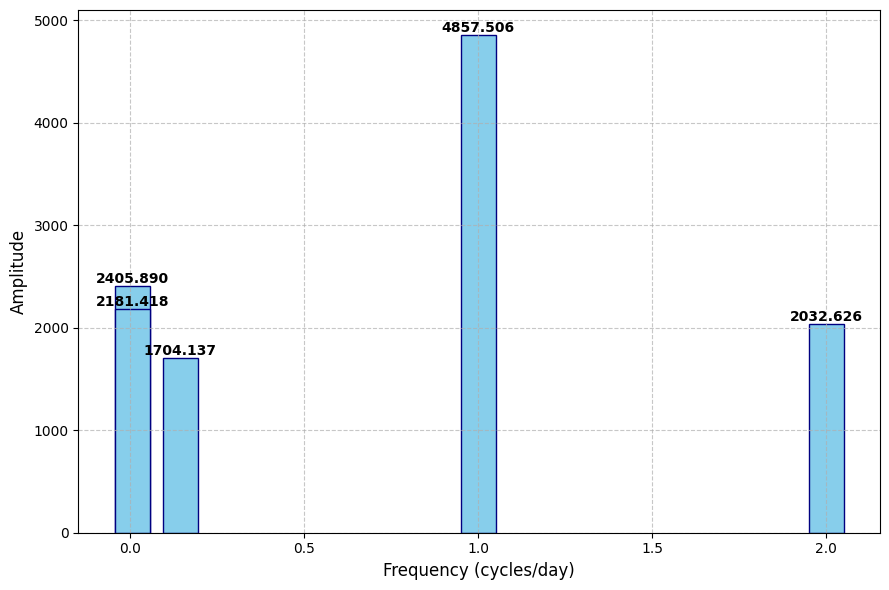

In [30]:
fig, ax = plt.subplots()
    
# Create bar plot
bars = ax.bar(top_frequencies, top_amplitudes, 
                color='skyblue',
                edgecolor='navy',
                width=0.1)  # Adjust width as needed

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontweight='bold')

# Customize the plot
ax.set_xlabel('Frequency (cycles/day)', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

## Model selection

In [31]:
import lightgbm as lgb
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences


In [32]:
models ={
        'lgbm': lgb.LGBMRegressor(verbosity=-1),
        'lasso': Lasso(),
        'lin_reg': LinearRegression(),
        'ridge': Ridge(),
        'knn': KNeighborsRegressor(),
        'gbr': GradientBoostingRegressor()
    }

In [33]:
mlf = MLForecast(
    models = models, 
    freq='H',
    target_transforms=[Differences([24, 168])],
    lags=[1,12,24,168],
    lag_transforms={  
        1: [ExpandingMean()],
        24: [RollingMean(window_size=24)],
    },
    date_features=['month', 'hour', 'dayofweek']
)

In [34]:
ml_cv_df = mlf.cross_validation(
    df=df_train,
    h=24,
    n_windows=7,
    step_size=24,
    refit=False,
)
ml_cv_df.head()

,unique_id,ds,cutoff,y,lgbm,lasso,lin_reg,ridge,knn,gbr
0,PJM,2001-12-24 01:00:00,2001-12-24,23811.0,23887.038,23846.651,23846.587,23846.587,24060.2,23876.441
1,PJM,2001-12-24 02:00:00,2001-12-24,22421.0,22528.231,22597.383,22597.255,22597.255,22832.2,22503.118
2,PJM,2001-12-24 03:00:00,2001-12-24,21629.0,22338.196,22465.497,22465.304,22465.304,23039.8,22390.908
3,PJM,2001-12-24 04:00:00,2001-12-24,21678.0,22689.637,22826.856,22826.597,22826.597,23332.2,22673.794
4,PJM,2001-12-24 05:00:00,2001-12-24,21634.0,23127.707,23394.614,23394.286,23394.286,23350.0,23167.040


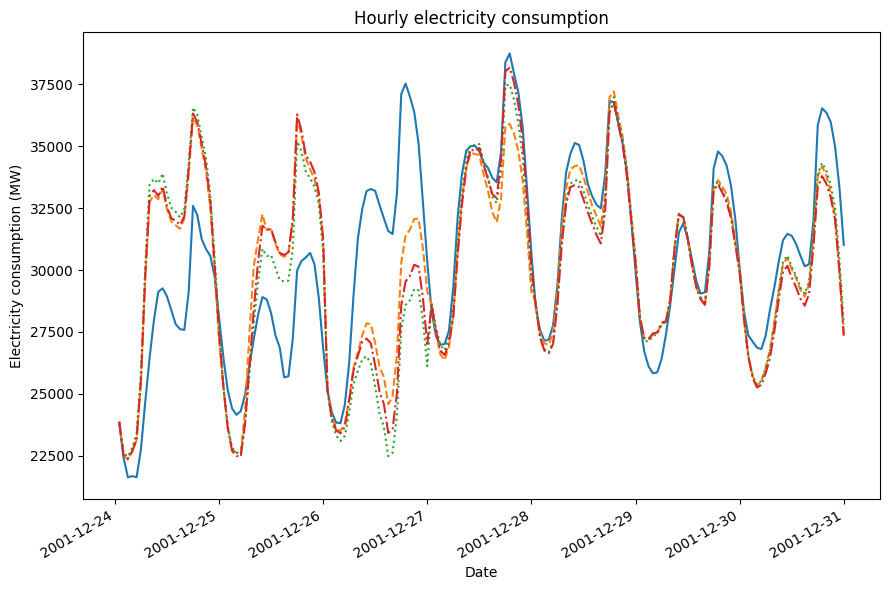

In [35]:
fig, ax = plt.subplots()

ax.plot(ml_cv_df['ds'], ml_cv_df['y'])
ax.plot(ml_cv_df['ds'], ml_cv_df['lgbm'], label='LightGBM', ls='--')
ax.plot(ml_cv_df['ds'], ml_cv_df['lasso'], label='Lasso', ls=':')
ax.plot(ml_cv_df['ds'], ml_cv_df['gbr'], label='GradientBoosting', ls='-.')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption (MW)')
ax.set_title('Hourly electricity consumption')

fig.autofmt_xdate()
plt.tight_layout()

In [36]:
eval_df = ml_cv_df.drop(['ds', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape])
evaluation

,unique_id,metric,lgbm,lasso,lin_reg,ridge,knn,gbr
0,PJM,mae,2014.631,2145.890,2148.416,2148.416,1882.780,2154.637
1,PJM,smape,0.033,0.036,0.036,0.036,0.032,0.036


In [37]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL

In [38]:
mstl = MSTL(season_length=[12, 24, 168],
            alias='MSTL')

sf = StatsForecast(models=[mstl], freq='H')
mstl_cv_df = sf.cross_validation(
    h=24, 
    df=df_train, 
    n_windows=7,
    step_size=24
)

eval_df = mstl_cv_df.drop(['ds', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape])
evaluation

,unique_id,metric,MSTL
0,PJM,mae,2100.315
1,PJM,smape,0.034


## Fit and predict with the best model

In [39]:
from mlforecast.utils import PredictionIntervals

In [40]:
models ={
        'lgbm': lgb.LGBMRegressor(verbosity=-1),
        'knn': KNeighborsRegressor(),
    }

mlf = MLForecast(
    models = models, 
    freq='H',
    target_transforms=[Differences([24, 168])],
    lags=[1,12,24,168],
    lag_transforms={  
        1: [ExpandingMean()],
        24: [RollingMean(window_size=24)],
    },
    date_features=['month', 'hour', 'dayofweek']
)

mlf.fit(
    df = df_train,
    prediction_intervals=PredictionIntervals(n_windows=4, h=24)
)

levels = [80] 
preds = mlf.predict(24, level=levels)
preds.head()


,unique_id,ds,lgbm,knn,lgbm-lo-80,lgbm-hi-80,knn-lo-80,knn-hi-80
0,PJM,2001-12-31 01:00:00,28986.532,29212.8,28785.701,29187.364,29063.92,29361.68
1,PJM,2001-12-31 02:00:00,28103.507,28902.0,27557.883,28649.131,28328.96,29475.04
2,PJM,2001-12-31 03:00:00,27329.970,28586.6,26223.787,28436.153,27781.82,29391.38
3,PJM,2001-12-31 04:00:00,27238.063,28297.2,25749.517,28726.609,27219.82,29374.58
4,PJM,2001-12-31 05:00:00,26910.969,27545.8,25568.514,28253.423,26569.80,28521.80


In [41]:
preds = preds.merge(df_test[['ds', 'y']], on='ds', how='left')

eval_df = preds.drop(['ds'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape], models=['lgbm', 'knn'])
evaluation

,unique_id,metric,lgbm,knn
0,PJM,mae,1425.674,1440.150
1,PJM,smape,0.021,0.021


## Analyzing our ML model

In [42]:
mlf.models_

{'lgbm': LGBMRegressor(verbosity=-1), 'knn': KNeighborsRegressor()}

In [43]:
mlf.models_['knn'].effective_metric_

'euclidean'

In [44]:
df_with_features = mlf.preprocess(df_train[-400:])
df_with_features.head()

,unique_id,ds,y,lag1,lag12,lag24,lag168,expanding_mean_lag1,rolling_mean_lag24_window_size24,month,hour,dayofweek
32832,PJM,2001-12-29 09:00:00,-1021.0,-392.0,-590.0,-670.0,575.0,-300.929,-548.958,12,9,5
32833,PJM,2001-12-29 10:00:00,-927.0,-1021.0,-381.0,-262.0,528.0,-305.189,-613.125,12,10,5
32834,PJM,2001-12-29 11:00:00,-443.0,-927.0,-330.0,-297.0,398.0,-308.847,-668.417,12,11,5
32835,PJM,2001-12-29 12:00:00,-200.0,-443.0,-520.0,-341.0,181.0,-309.632,-700.042,12,12,5
32836,PJM,2001-12-29 13:00:00,22.0,-200.0,-599.0,-601.0,468.0,-308.994,-741.667,12,13,5


In [45]:
X = df_with_features.drop(columns=['unique_id', 'ds', 'y'])

In [46]:
import shap

X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(mlf.models_['lgbm'].predict, X100)
shap_values = explainer(X)


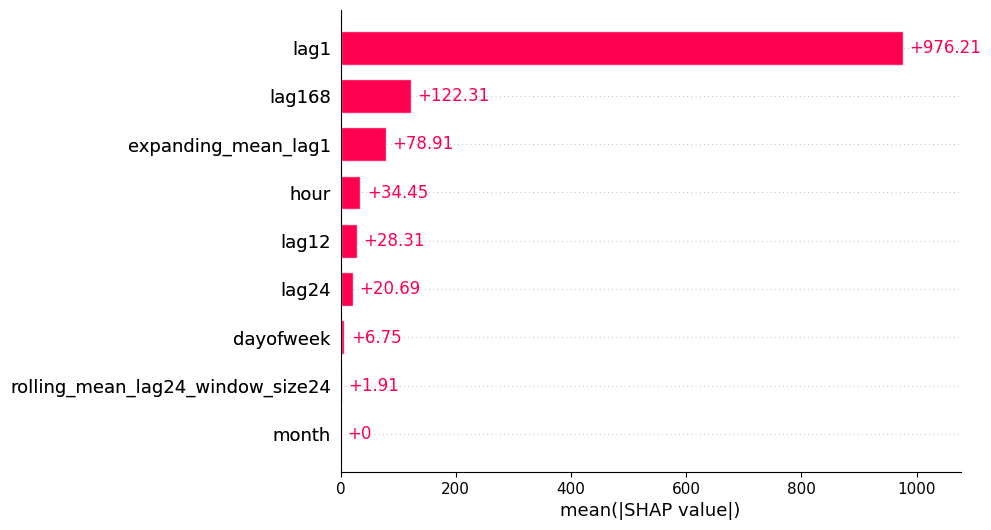

In [47]:
shap.plots.bar(shap_values, show=False);

### Explain a single prediction

In [48]:
from mlforecast.callbacks import SaveFeatures

In [49]:
save_feats = SaveFeatures()
xpl_preds = mlf.predict(1, before_predict_callback=save_feats)
xpl_preds.head()

,unique_id,ds,lgbm,knn
0,PJM,2001-12-31 01:00:00,29008.987,29212.8


In [50]:
features = save_feats.get_features()
features.head()

,lag1,lag12,lag24,lag168,expanding_mean_lag1,rolling_mean_lag24_window_size24,month,hour,dayofweek
0,4235.0,2444.0,637.0,-2277.0,67.019,-132.208,12,1,0
1,4235.0,2444.0,637.0,-2277.0,67.019,-132.208,12,1,0


In [51]:
shap_values_predictions = explainer(features)

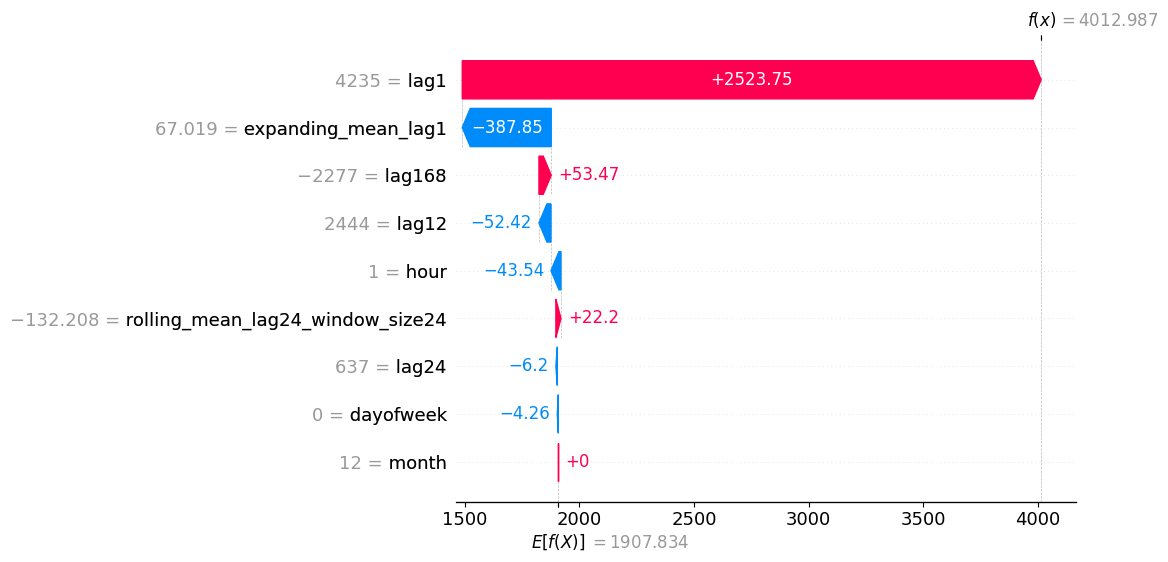

In [52]:
shap.plots.waterfall(shap_values_predictions[0])